In [60]:

import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt
import utils
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops

from scipy.ndimage import zoom


In [61]:
import pandas as pd
import numpy as np
import os
import zipfile
import shutil
import math

In [62]:
# data preprocessing

data_path1 = '/Users/zack/zack/deep_learning/Play/'
#read oasis_data
labels = pd.read_csv("oasis_label_2.csv")
# days since MRI
labels['Days since MRI'] = pd.to_numeric(labels['Label'].str[-4:])
# month and two month since MRI
labels['Months since MRI'] = np.floor(labels['Days since MRI']/30)
labels['2 months since MRI'] = np.floor(labels['Days since MRI']/60)
# drop subjects who have two mri at the same day 
new = labels
new = new.drop_duplicates(subset=['Subject','2 months since MRI'])
# sort by subject and then months since mri
sorted_labels = new.sort_values(by=['Subject','Months since MRI'])

# need to change format since MRI format is OAS30073_MR_d3670.nii, 
# but nameID on excel file format is OAS30073_ClinicalData_d3670
# OAS30001_ClinicalData_d0000 -> OAS30001_MR_d0000.nii


def rep(s):
    x = s.replace("_ClinicalData_","_MR_")
    return x
sorted_labels['New Label'] = sorted_labels['Label'].apply(rep) + '.nii'

# divide sorted_label into 3 label-normal, uncertain and AD_labels
normal_labels = sorted_labels[sorted_labels['dx1'] == 'Cognitively normal']
uncertain_labels = sorted_labels[sorted_labels['dx1'] == 'uncertain dementia']
AD_labels = sorted_labels[sorted_labels['dx1'] == 'AD Dementia']


sorted_labels['New Label'] = sorted_labels['Label'].apply(rep) + '.nii'
######################################################################################################################

# oasis_image_data_dates.csv matches sorted_labels
image_data = pd.read_csv("oasis_image_data_dates.csv")


def match(df, col1 = 'subject',col2 = 'days'):
    df1=sorted_labels[sorted_labels["Subject"]==df[col1]]
    loc = (np.abs(df1["Days since MRI"] - df[col2])).argmin()            
    low_limit = df[col2] - 180
    high_limit = df[col2] + 180
    if sorted_labels.loc[loc]['Days since MRI'] < high_limit and sorted_labels.loc[loc]['Days since MRI'] > low_limit:
#         #here return dx1 other than the nearest day
#         return int(sorted_labels.loc[loc]['Days since MRI'])
        return sorted_labels.loc[loc]['dx1']

    else:
        return None
image_data["match_label"] = image_data.apply(match,col1 = 'subject',col2 = 'days',axis = 1)
image_data.head()


# def match(day_file,subj_file,excel):
#     df1=excel[excel["Subject"]==subj_file]
#     loc = (np.abs(df1["Days since MRI"] - day_file)).argmin()            
#     low_limit = day_file - 180
#     high_limit = day_file + 180
#     if excel.loc[loc]['Days since MRI'] < high_limit and excel.loc[loc]['Days since MRI'] > low_limit:
#         return excel.loc[loc]['Days since MRI']
#     else:
#         return None
# df['nearest'] = df.apply(lambda x: match(x['days'],x['subject'],sorted_labels),axis=1) 
# df.head()

#get sample file name for AD NORMAL AND UNCERTAIN

sample_normal = image_data[image_data['match_label'] == 'Cognitively normal'].head(2)
normal_file_name = sample_normal['actual file name'].values

sample_AD = image_data[image_data['match_label'] == 'AD Dementia'].head(2)
AD_file_name = sample_AD['actual file name'].values

sample_uncertain = image_data[image_data['match_label'] == 'uncertain dementia'].head(2)
uncertain_file_name = sample_uncertain['actual file name'].values


/Users/zack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


In [63]:
sample_AD

,Count,actual file name,subject,type,file_name_day,day label,days,match_label
53,19508,OAS30024_MR_d0084.nii.gz,OAS30024,MR,d0084.nii.gz,d0084,84,AD Dementia
61,18887,OAS30027_MR_d2394.nii.gz,OAS30027,MR,d2394.nii.gz,d2394,2394,AD Dementia


In [64]:
# get sample data
data_path = '/Users/zack/zack/deep_learning/Play/'
files = os.listdir(data_path1)

#read data
X = np.zeros((6,128,128,128))
Y = np.zeros((6,1))
i = 0
# 0 is normal 1 is ad and 2 is uncertain
for data_file in files:
    for normal_name in normal_file_name:
        if data_file == normal_name:
            X[i] = zoom(nibabel.load(data_path + data_file).get_data(),(0.5, 0.5, 0.5))
            Y[i] = 0
            i += 1
    for AD_name in AD_file_name:
        if data_file == AD_name:
            X[i] = zoom(nibabel.load(data_path + data_file).get_data(),(0.5, 0.5, 0.5))
            Y[i] = 1
            i += 1
    for uncertain_name in uncertain_file_name:
        if data_file == uncertain_name:
            X[i] = zoom(nibabel.load(data_path + data_file).get_data(),(0.5, 0.5, 0.5))
            Y[i] = 2
            i += 1
    if i == 150:
             
        break    

In [65]:
# split into train and test

indices = np.random.permutation(X.shape[0])
indices

training_idx, test_idx = indices[:3], indices[3:]
Y = pd.get_dummies(Y.squeeze()).values


X_train, X_test = X[training_idx], X[test_idx]
Y_train, Y_test = Y[training_idx,:], Y[test_idx,:]

y_test_cls = Y_test.squeeze()
y_train_cls = Y_train.squeeze()
y_test_cls.shape



print(X_train.shape ,X_test.shape ,Y_train.shape,Y_test.shape,y_test_cls.shape,y_train_cls.shape)

(3, 128, 128, 128) (3, 128, 128, 128) (3, 3) (3, 3) (3, 3) (3, 3)


In [66]:
# add an channel at the end

In [67]:
#2d -> 3d 
X_train /= 255
X_test /= 255
X_train = X_train[:,:,:,:,np.newaxis]
X_test = X_test[:,:,:,:,np.newaxis]
print(X_train.shape ,X_test.shape ,Y_train.shape,Y_test.shape,y_test_cls.shape,y_train_cls.shape)

(3, 128, 128, 128, 1) (3, 128, 128, 128, 1) (3, 3) (3, 3) (3, 3) (3, 3)


In [71]:
# cov > pooling > cov2 > pooling2 > fc >fc2 > softmax

In [72]:
def create_placeholders(n_M0, n_H0, n_W0, n_C0, n_y):
    """
    Arguments:
    n_M0 -- scalar, how many image one second
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    """
    X = tf.placeholder(tf.float32, shape=(None,n_M0,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

def initialize_parameters():

    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    W1 = tf.get_variable('W1',[4,4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV3D -> RELU -> MAXPOOL -> CONV3D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    

    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv3d(X,W1, strides = [1,1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool3d(A1, ksize = [1,8,8,8,1], strides = [1,8,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv3d(P1,W2,strides = [1,1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool3d(A2,ksize = [1,4,4,4,1],strides=[1,4,4,4,1],padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 3 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 3,activation_fn=None)

    return Z3
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

def random_mini_batches(X, Y, mini_batch_size = 3, seed = 0):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
      
        mini_batch_X =  shuffled_X[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[mini_batch_size * k : (k+1) * mini_batch_size,:]
       
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : ,: ]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : ,:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 5, minibatch_size = 3, print_cost = True):
    ops.reset_default_graph()                         
    
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m,n_M0, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    
    X, Y = create_placeholders(n_M0=n_M0, n_H0=n_H0, n_W0=n_W0, n_C0=n_C0, n_y=n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)


            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run(optimizer,feed_dict={X:minibatch_X,Y:minibatch_Y}),sess.run(cost,feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch % 1 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
                
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters
    

Cost after epoch 0: 0.878387
Cost after epoch 1: 0.635648
Cost after epoch 2: 0.652246
Cost after epoch 3: 0.467994
Cost after epoch 4: 0.400501


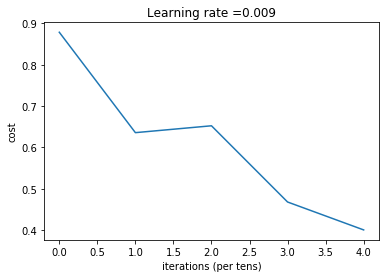

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.33333334


In [73]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)